# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [118]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

# Funciones de visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones de clustering
from sklearn import manifold, preprocessing, decomposition
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Funciones propias
from utils_limpieza import * 

# Clear preferencias
plt.rcdefaults()
pd.reset_option('^display\.float_format')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Preparación de Datos <span style="color:magenta">**(Paso 1)**</span>

In [119]:
vectores = pd.read_csv('../data/interim/tp3_Fven_limpio_ceros.csv')
vectores

,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,...,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206
0,0,Miscelaneo,0,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,0.000000,...,-0.954996,-0.954996,0.035706,1.598752,17.949262,17.949262,-0.011453,-0.661136,0.032632,-0.240964
1,1,Miscelaneo,0,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,...,-0.202242,-0.348981,-0.031099,0.900433,-0.155532,0.492585,0.227850,-0.151318,1.190775,0.390497
2,2,Miscelaneo,0,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,-0.134293,...,0.240366,0.611252,-0.073709,-0.088358,-0.378793,-0.386948,-0.409333,-0.361089,0.010926,-0.265505
3,4,Gondola,0,0.193896,0.072714,-0.055670,0.027243,-0.173982,0.008415,0.003202,...,0.066091,0.140059,-0.115213,-0.036514,-0.431350,-0.373287,-0.174904,-0.235093,-0.004616,0.187411
4,5,Venta Agrop.,0,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,...,0.420448,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3790,2973,Farmacia,0,0.067191,0.168471,0.223234,0.204894,0.033863,0.270882,-0.058344,...,0.414907,0.264124,-0.022700,0.329191,-0.122775,-0.156125,0.013776,-0.248115,0.026706,0.146889
3791,2974,Gondola,0,0.533815,0.271578,-0.197582,0.336976,2.397581,2.189153,0.475121,...,1.523125,9.035588,2.327344,2.281358,-0.812570,-0.934353,-0.814483,-0.820076,0.155693,0.641247
3792,2975,Farmacia,0,-0.007857,0.163375,0.435761,-0.087601,-0.334698,0.472357,-0.349948,...,0.115770,-0.349470,-0.258736,-0.274901,-0.496001,0.141077,-0.716947,-0.498321,-0.593563,-0.677739
3793,2977,Miscelaneo,0,-0.295017,-0.388342,-0.364785,-0.302340,0.413482,1.373845,0.137661,...,0.014053,-0.233204,-0.622248,-0.405013,-0.595008,-0.333223,0.005831,0.102510,1.123445,0.123052


In [120]:
# Definir grupos de variables:

F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 
         'F_pct_Com_1909', 'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912',
         'F_pct_Com_2001', 'F_pct_Com_2002', 'F_pct_Com_2003', 'F_pct_Com_2004',
         'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007', 'F_pct_Com_2008',
         'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
         'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104',
         'F_pct_Com_2105', 'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108',
         'F_pct_Com_2109', 'F_pct_Com_2110', 'F_pct_Com_2111', 'F_pct_Com_2112',
         'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203', 'F_pct_Com_2204',
         'F_pct_Com_2205', 'F_pct_Com_2206']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004',
         'Y_pct_Com_2005', 'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008',
         'Y_pct_Com_2009', 'Y_pct_Com_2010', 'Y_pct_Com_2011', 'Y_pct_Com_2012',
         'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103', 'Y_pct_Com_2104',
         'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
         'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112',
         'Y_pct_Com_2201', 'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204',
         'Y_pct_Com_2205', 'Y_pct_Com_2206']

Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004',
         'Y_pct_Ven_2005', 'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008',
         'Y_pct_Ven_2009', 'Y_pct_Ven_2010', 'Y_pct_Ven_2011', 'Y_pct_Ven_2012',
         'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103', 'Y_pct_Ven_2104',
         'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
         'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112',
         'Y_pct_Ven_2201', 'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204',
         'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

basics = ['Modelo', 'Subrubro']

## Para todos los Subrubros juntos

### Aplico MinMax

In [71]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
# Aplicar el escalado Min-Max solo a las columnas seleccionadas
vectores[F_Ven] = scaler.fit_transform(vectores[F_Ven])
vectores

,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,...,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206
0,0,Miscelaneo,0,0.040052,0.207142,0.091597,0.310098,0.000828,0.006024,0.082865,...,0.696447,0.637837,0.119468,0.044550,0.195039,0.034308,0.064738,0.764976,0.329132,0.075937
1,1,Miscelaneo,0,0.040000,0.207188,0.088212,0.309797,0.000782,0.005874,0.082336,...,0.697557,0.639888,0.119110,0.043774,0.145303,0.024711,0.065098,0.765241,0.330408,0.076098
2,2,Miscelaneo,0,0.038575,0.204975,0.090082,0.310288,0.000801,0.006084,0.082441,...,0.698210,0.643138,0.118882,0.042675,0.144689,0.024228,0.064141,0.765132,0.329108,0.075931
3,4,Gondola,0,0.039046,0.205279,0.087814,0.310129,0.000810,0.006027,0.082875,...,0.697953,0.641543,0.118660,0.042733,0.144545,0.024235,0.064493,0.765197,0.329091,0.076046
4,5,Venta Agrop.,0,0.043039,0.220434,0.084694,0.310289,0.000745,0.006062,0.088016,...,0.698475,0.642118,0.116677,0.043204,0.144754,0.023991,0.064721,0.765213,0.328828,0.078578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3790,2973,Farmacia,0,0.038717,0.205631,0.089473,0.310330,0.000832,0.006118,0.082681,...,0.698467,0.641963,0.119155,0.043139,0.145393,0.024355,0.064776,0.765191,0.329126,0.076036
3791,2974,Gondola,0,0.039931,0.206009,0.086970,0.310479,0.001077,0.006788,0.084362,...,0.700101,0.671647,0.131750,0.045309,0.143498,0.023927,0.063533,0.764893,0.329268,0.076161
3792,2975,Farmacia,0,0.038521,0.205612,0.090737,0.309999,0.000793,0.006189,0.081761,...,0.698026,0.639887,0.117890,0.042468,0.144367,0.024518,0.063679,0.765061,0.328442,0.075826
3793,2977,Miscelaneo,0,0.037774,0.203588,0.085975,0.309757,0.000871,0.006503,0.083299,...,0.697876,0.640280,0.115942,0.042323,0.144095,0.024257,0.064764,0.765373,0.330334,0.076030


### Aplico PCA a 12 componentes

In [72]:
pca=decomposition.PCA(n_components=12) #elegimos 2, 3 o 4 pero pueden ser más

pca.fit(vectores[F_Ven])

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

vectores_pca=pca.transform(vectores[F_Ven]) #numpy array
vectores_pca = pd.DataFrame(data=vectores_pca, columns=[f'PC{i}' for i in range(1, 13)]).copy()

print ('tamaño de los datos: ', vectores_pca.shape)
vectores_pca

proporción de varianza por componente:  [0.11154604 0.08975312 0.07903554 0.05921574 0.05332186 0.05229703
 0.04954367 0.03714245 0.0340358  0.03073772 0.02934766 0.02810534]
proporción de varianza por componente acumulada:  [0.11154604 0.20129916 0.2803347  0.33955045 0.39287231 0.44516934
 0.49471301 0.53185545 0.56589126 0.59662898 0.62597664 0.65408198]
tamaño de los datos:  (3795, 12)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.197585,0.633161,0.112698,0.573676,-0.372860,0.431977,-0.535902,0.019931,-0.010510,0.037570,-0.006097,-0.056803
1,-0.002006,-0.007958,-0.001249,-0.000951,-0.002310,0.000269,-0.000559,-0.001672,-0.004953,0.000753,-0.002996,-0.000513
2,0.000207,0.011920,0.007710,0.019154,-0.019634,0.020300,-0.024100,-0.006203,0.000411,0.001284,0.003979,-0.006362
3,-0.006820,-0.006043,-0.005651,-0.000846,-0.003431,0.000855,0.000317,-0.002637,-0.002593,-0.000817,0.000274,0.001040
4,-0.006991,0.003229,-0.007637,0.006276,0.000015,-0.000737,0.009379,0.011259,-0.008330,-0.001685,-0.001163,-0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...
3790,-0.008784,-0.002905,-0.002383,0.000043,-0.003837,0.002142,-0.002545,-0.003083,-0.002134,-0.000501,-0.000474,-0.001465
3791,-0.012306,-0.002178,-0.008502,0.003719,-0.000456,0.001919,-0.002776,0.004765,0.022637,-0.012093,0.000562,-0.001671
3792,-0.015054,-0.001910,-0.001543,-0.003312,-0.003359,0.000640,-0.000807,-0.002480,-0.002448,0.001370,-0.001014,0.000784
3793,-0.014238,-0.004432,0.000770,0.000352,-0.002871,0.000744,0.003152,-0.002801,-0.003333,0.005788,0.000162,0.003192


### Elijo el nro de clusters con el método del codo

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

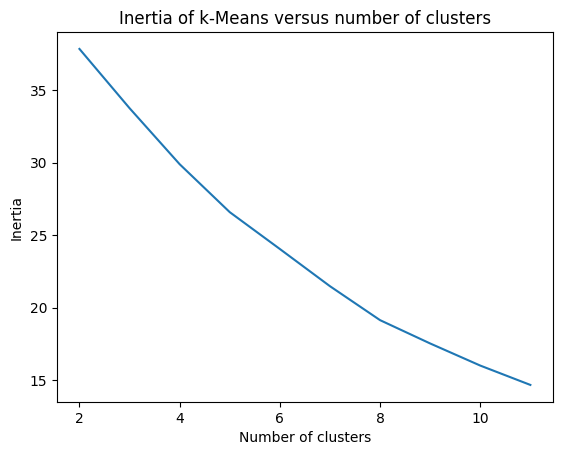

In [73]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_pca).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [74]:
# Encontrar el número recomendado de clusters (punto del codo)
# Encuentra la primera derivada (diferencia entre puntos sucesivos)
differences = np.diff(scores)

# Encuentra el punto del codo (donde la primera derivada cambia más)
recommended_num_clusters = np.where(differences == max(differences))[0][0] + 2  # +2 para compensar el rango de inicio

print("Número recomendado de clusters:", recommended_num_clusters)

Número recomendado de clusters: 10


### Aplico KMeans

In [75]:
km = KMeans(n_clusters=recommended_num_clusters, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_pca)
clusters = km.labels_

### Aplico PCA en dos componentes para graficar

In [76]:
pca=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más

pca.fit(vectores_pca)

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

vectores_pca_2=pca.transform(vectores_pca) #numpy array
vectores_pca_2 = pd.DataFrame(data=vectores_pca_2, columns=[f'PC{i}' for i in range(1, 3)]).copy()

print ('tamaño de los datos: ', vectores_pca_2.shape)
vectores_pca_2

proporción de varianza por componente:  [0.17052701 0.1372109 ]
proporción de varianza por componente acumulada:  [0.17052701 0.30773791]
tamaño de los datos:  (3795, 2)


,PC1,PC2
0,0.197585,0.633161
1,-0.002006,-0.007958
2,0.000207,0.011920
3,-0.006820,-0.006043
4,-0.006991,0.003229
...,...,...
3790,-0.008784,-0.002905
3791,-0.012306,-0.002178
3792,-0.015054,-0.001910
3793,-0.014238,-0.004432


### Agrego etiquetas y otras variables para graficar

In [77]:
vectores_clusters = vectores_pca_2.copy()
vectores_clusters['kmeans_n'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters

Kmeans encontró:  10 clusters, nosotros forzamos la cantidad


,PC1,PC2,kmeans_n
0,0.197585,0.633161,7
1,-0.002006,-0.007958,1
2,0.000207,0.011920,1
3,-0.006820,-0.006043,1
4,-0.006991,0.003229,1
...,...,...,...
3790,-0.008784,-0.002905,1
3791,-0.012306,-0.002178,1
3792,-0.015054,-0.001910,1
3793,-0.014238,-0.004432,1


In [78]:
vectores_clusters['kmeans_n'].value_counts()

kmeans_n
1    3677
0      68
2      15
5      12
6      10
4       6
9       3
7       2
8       1
3       1
Name: count, dtype: int64

In [79]:
vectores_clusters = pd.concat([vectores[basics], vectores_clusters], axis=1)
vectores_clusters

,Modelo,Subrubro,PC1,PC2,kmeans_n
0,0,Miscelaneo,0.197585,0.633161,7
1,0,Miscelaneo,-0.002006,-0.007958,1
2,0,Miscelaneo,0.000207,0.011920,1
3,0,Gondola,-0.006820,-0.006043,1
4,0,Venta Agrop.,-0.006991,0.003229,1
...,...,...,...,...,...
3790,0,Farmacia,-0.008784,-0.002905,1
3791,0,Gondola,-0.012306,-0.002178,1
3792,0,Farmacia,-0.015054,-0.001910,1
3793,0,Miscelaneo,-0.014238,-0.004432,1


### Grafico

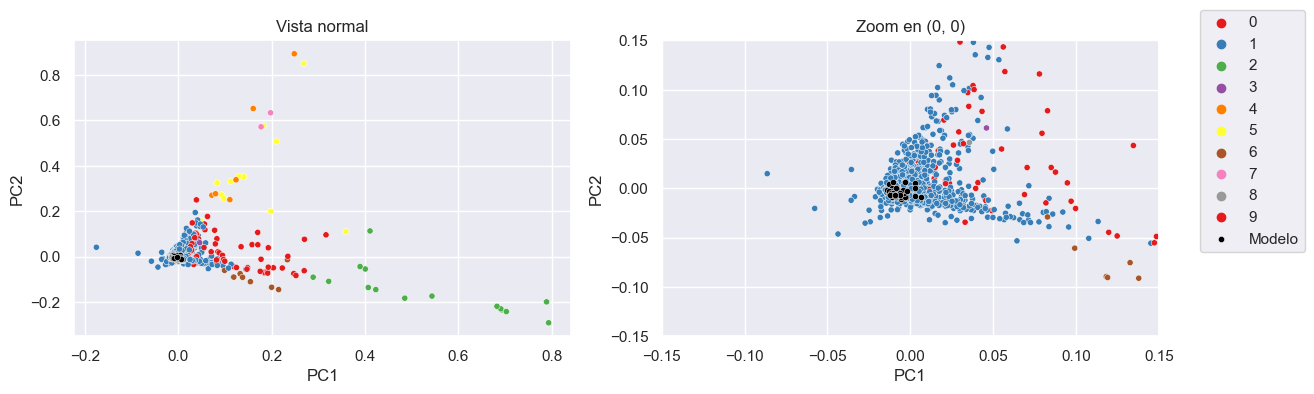

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que vectores_clusters contiene tus datos

# Crear una figura con dos subtramas en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_title("Vista normal")
axs[1].set_title("Zoom en (0, 0)")

# Configurar el pairplots en ambas subtramas
for ax in axs:
    sns.scatterplot(data=vectores_clusters, x='PC1', y='PC2', hue='kmeans_n', palette='Set1', s=20, ax=ax)

# Filtrar los valores donde Modelo == 1
filt_modelo_1 = vectores_clusters['Modelo'] == 1

# Personalizar el tamaño y color de los puntos donde Modelo == 1
for ax in axs:
    sns.scatterplot(data=vectores_clusters[filt_modelo_1], x='PC1', y='PC2', color='black', s=20, label='Modelo', ax=ax)

# Establecer los límites de los ejes en la segunda subtrama (Zoom)
axs[1].set_xlim(-0.15, 0.15)
axs[1].set_ylim(-0.15, 0.15)

# Eliminar las leyendas de las subtramas individuales
for ax in axs:
    ax.get_legend().remove()

# Agregar una única leyenda fuera de las subtramas
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))

# Mostrar el gráfico completo
plt.tight_layout()
plt.show()

## Por subrubro

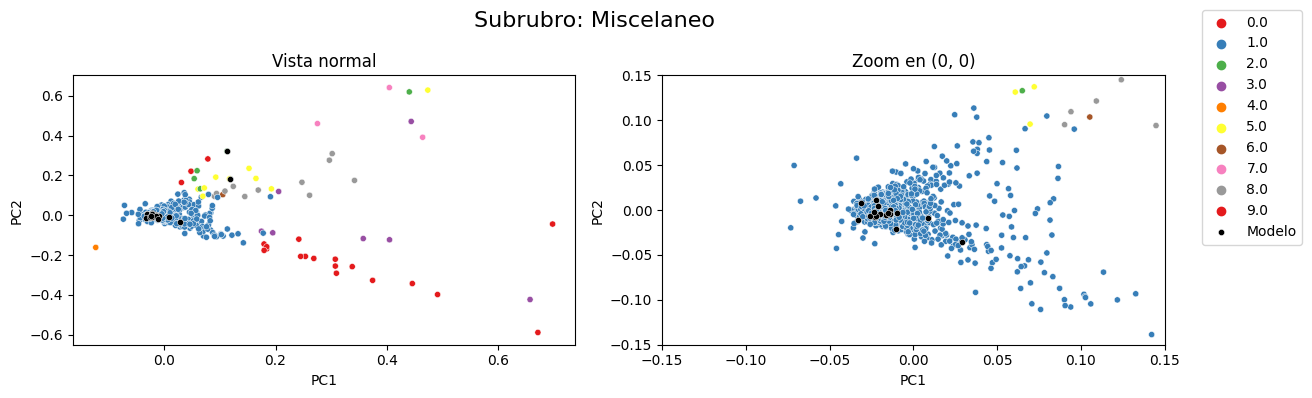

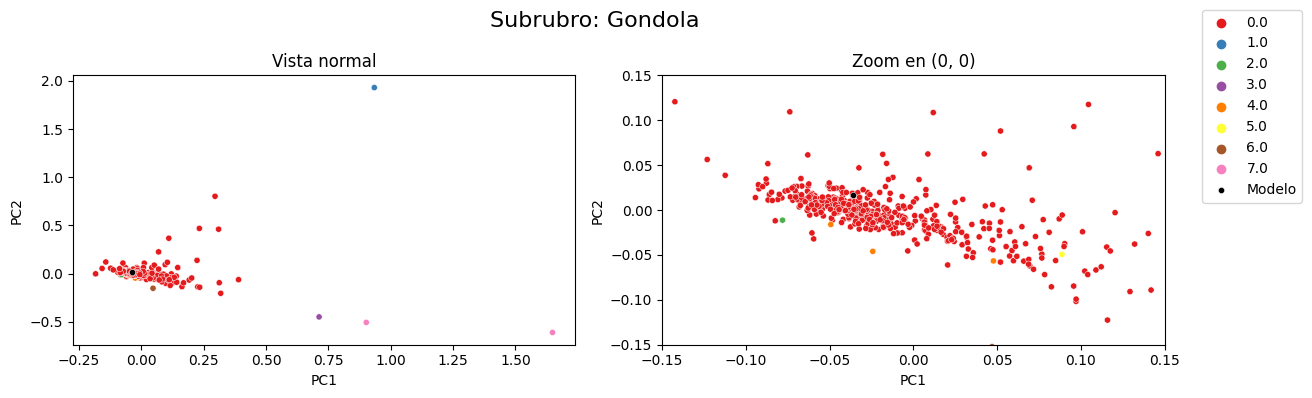

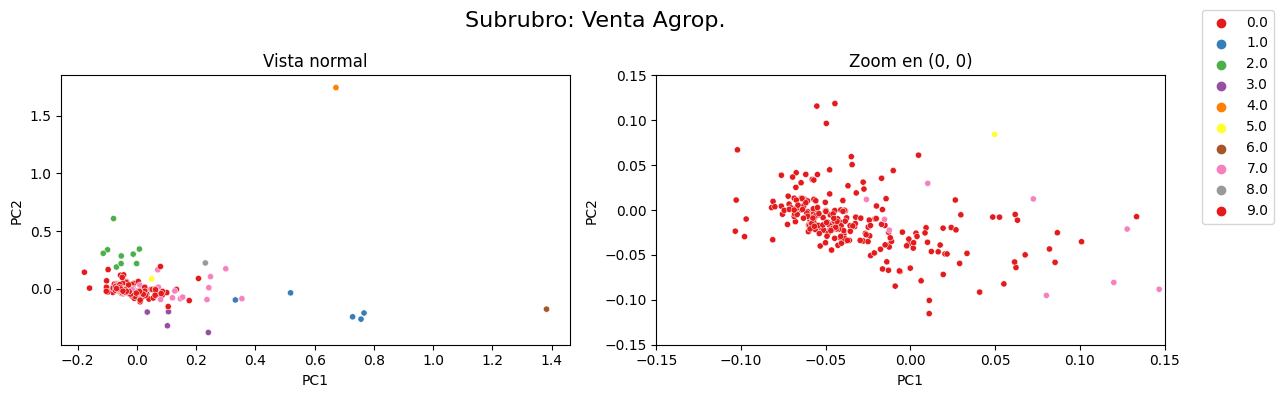

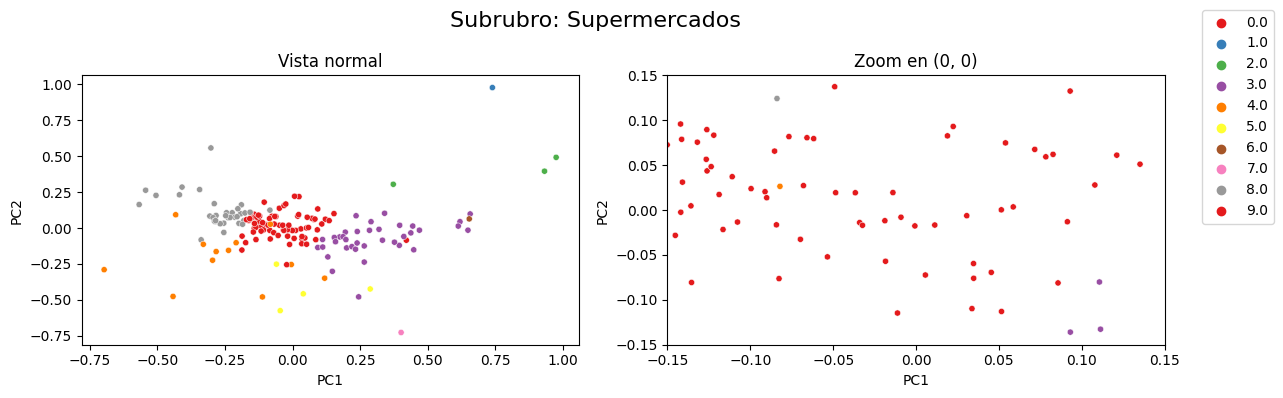

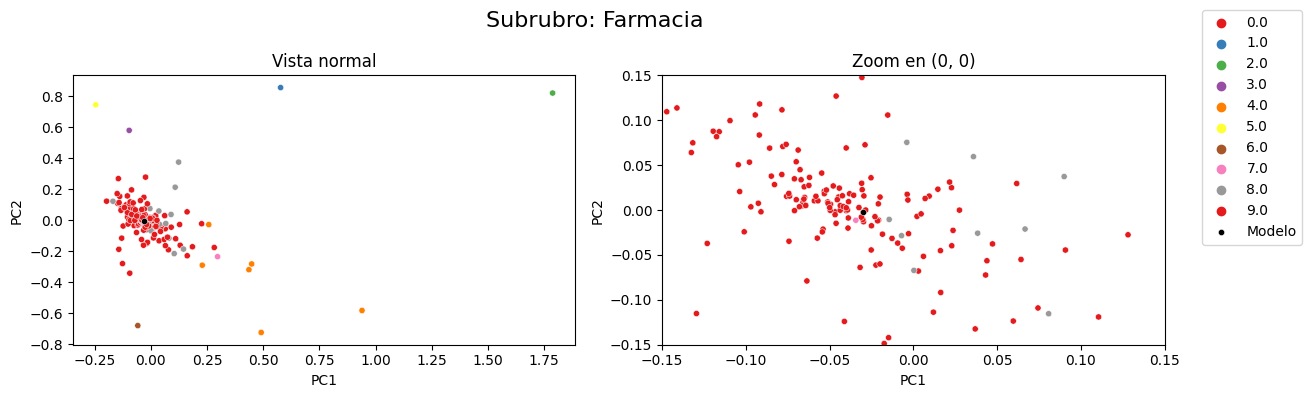

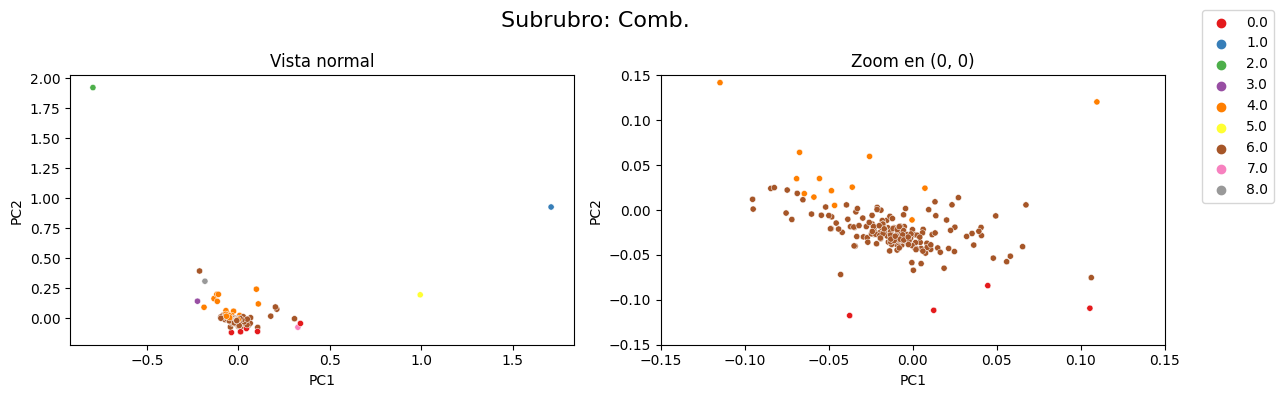

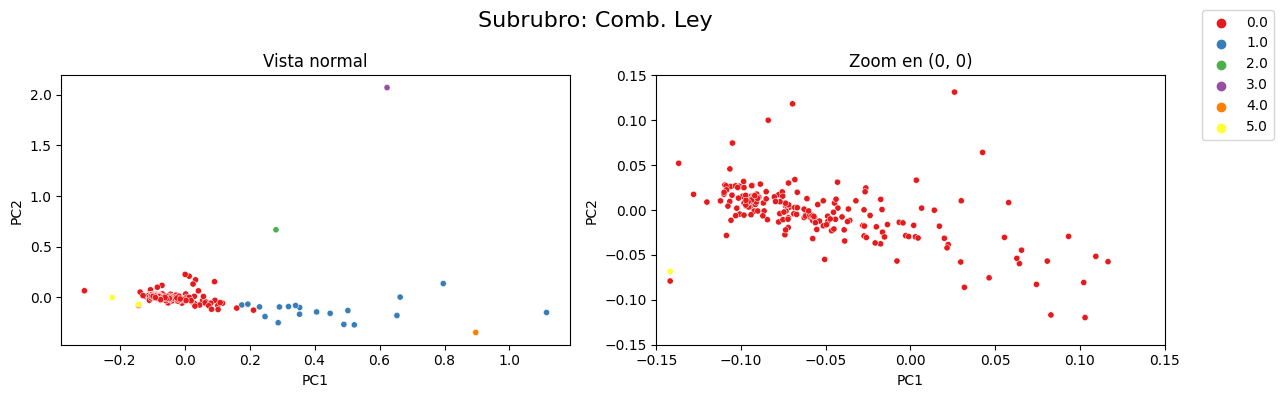

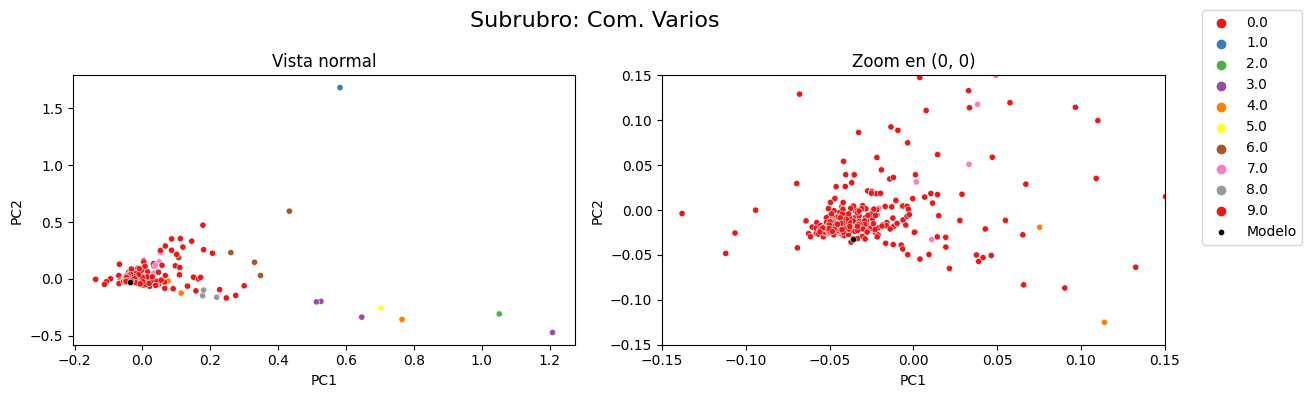

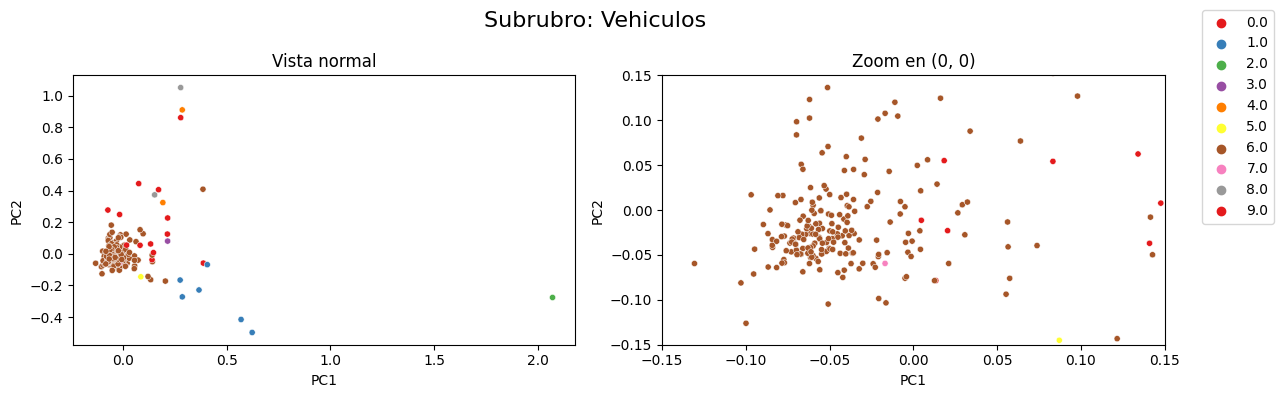

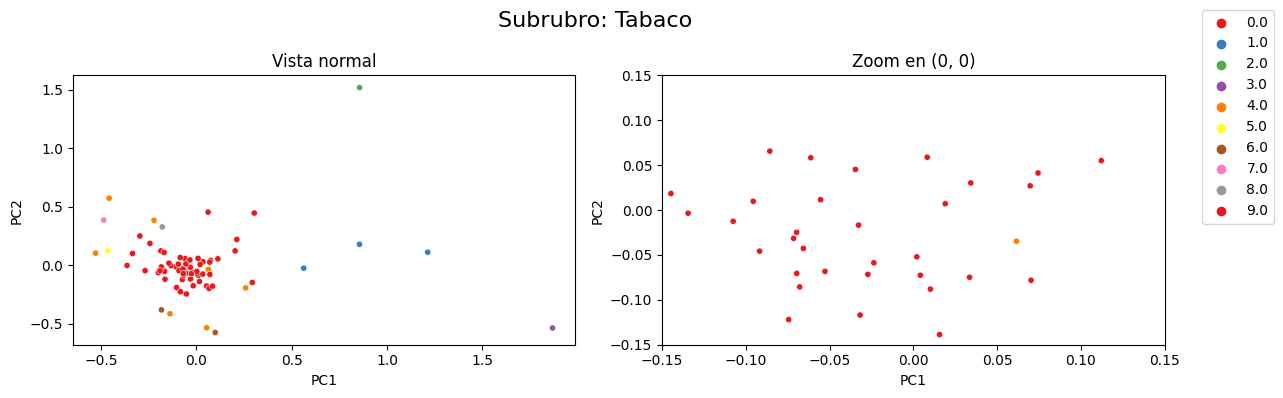

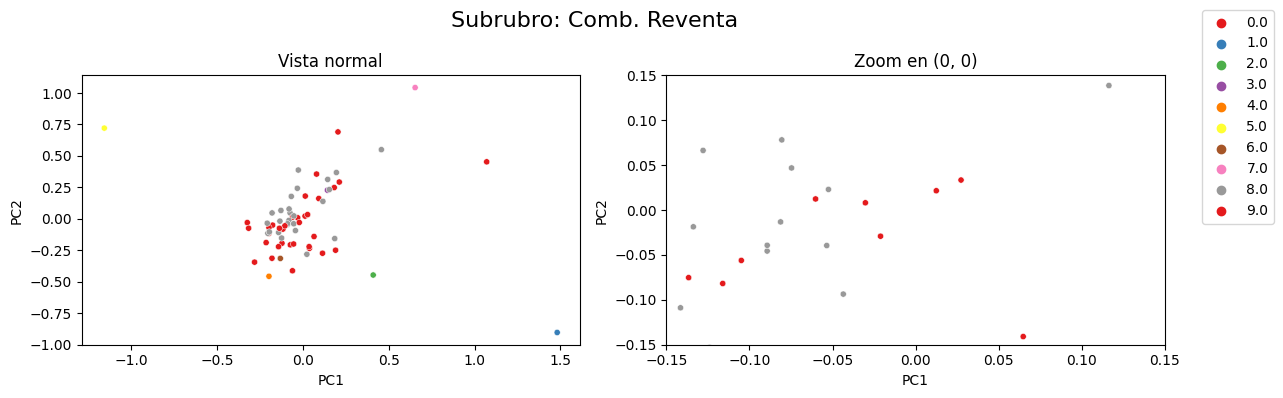

In [127]:
vectores = pd.read_csv('../data/interim/tp3_Fven_limpio_ceros.csv')

# Identificar subrubros
unique_subrubros = vectores['Subrubro'].unique()

# Itera sobre los subrubros únicos y crea gráficos para cada uno
for subrubro in unique_subrubros:
    subrubro_df = vectores[vectores['Subrubro'] == subrubro].copy()
    
    # Escala MinMax
    scaler = MinMaxScaler()
    subrubro_df[F_Ven] = scaler.fit_transform(subrubro_df[F_Ven])

    # PCA de 12 componentes
    pca = decomposition.PCA(n_components=12)
    pca.fit(subrubro_df[F_Ven])
    subrubro_df_pca = pca.transform(subrubro_df[F_Ven])
    subrubro_df_pca = pd.DataFrame(data=subrubro_df_pca, columns=[f'PC{i}' for i in range(1, 13)]).copy()

    # Nro de clusters recomendado por el codo
    scores = [KMeans(n_clusters=i, n_init=10).fit(subrubro_df_pca).inertia_ for i in range(2, 12)]
    differences = np.diff(scores)
    recommended_num_clusters = np.where(differences == max(differences))[0][0] + 2

    # KMeans
    km = KMeans(n_clusters=recommended_num_clusters, n_init=10)
    km.fit(subrubro_df_pca)
    clusters = km.labels_

    # PCA de 2 componentes para visualizar
    pca = decomposition.PCA(n_components=2)
    pca.fit(subrubro_df_pca)
    subrubro_df_pca_2 = pca.transform(subrubro_df_pca)  # numpy array
    subrubro_df_pca_2 = pd.DataFrame(data=subrubro_df_pca_2, columns=[f'PC{i}' for i in range(1, 3)]).copy()
    subrubro_df_clusters = subrubro_df_pca_2.copy()
    subrubro_df_clusters['kmeans_n'] = km.labels_
    subrubro_df_clusters = pd.concat([subrubro_df[basics], subrubro_df_clusters], axis=1)

    # Gráfico
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Subrubro: {subrubro}", fontsize=16)
    axs[0].set_title("Vista normal")
    axs[1].set_title("Zoom en (0, 0)")
    for ax in axs:
        sns.scatterplot(data=subrubro_df_clusters, x='PC1', y='PC2', hue='kmeans_n', palette='Set1', s=20, ax=ax)
    filt_modelo_1 = subrubro_df_clusters['Modelo'] == 1
    for ax in axs:
        sns.scatterplot(data=subrubro_df_clusters[filt_modelo_1], x='PC1', y='PC2', color='black', s=20, label='Modelo', ax=ax)
    axs[1].set_xlim(-0.15, 0.15)
    axs[1].set_ylim(-0.15, 0.15)
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

#### Fuerzo que elija 2 clusters

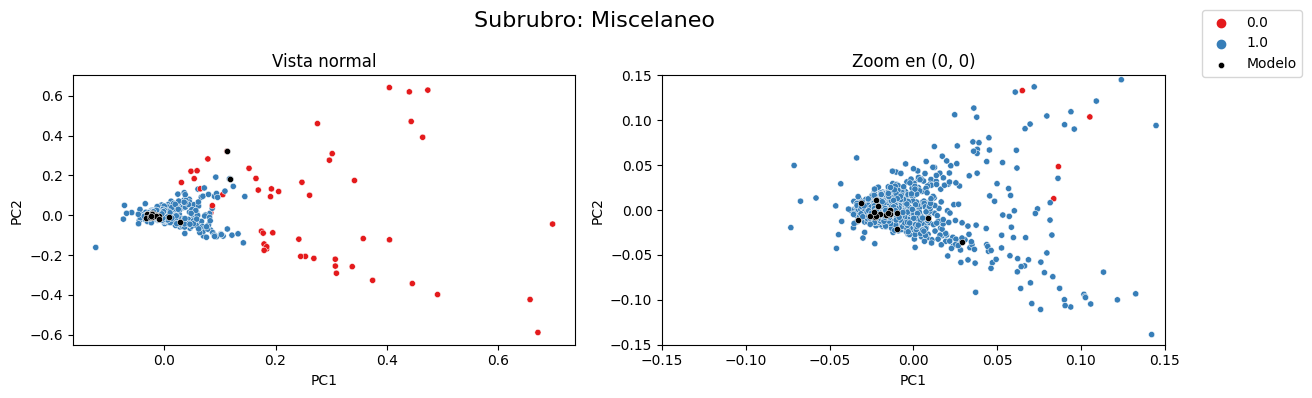

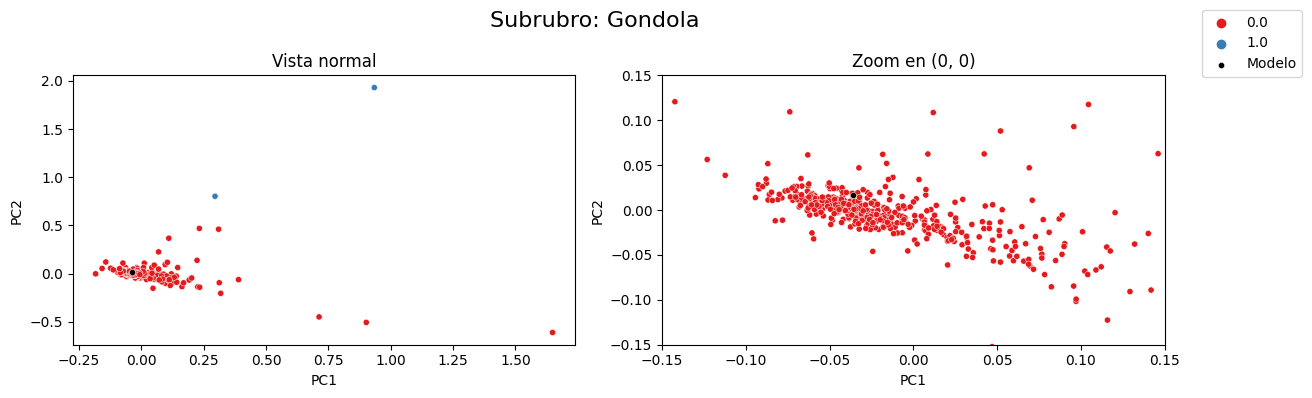

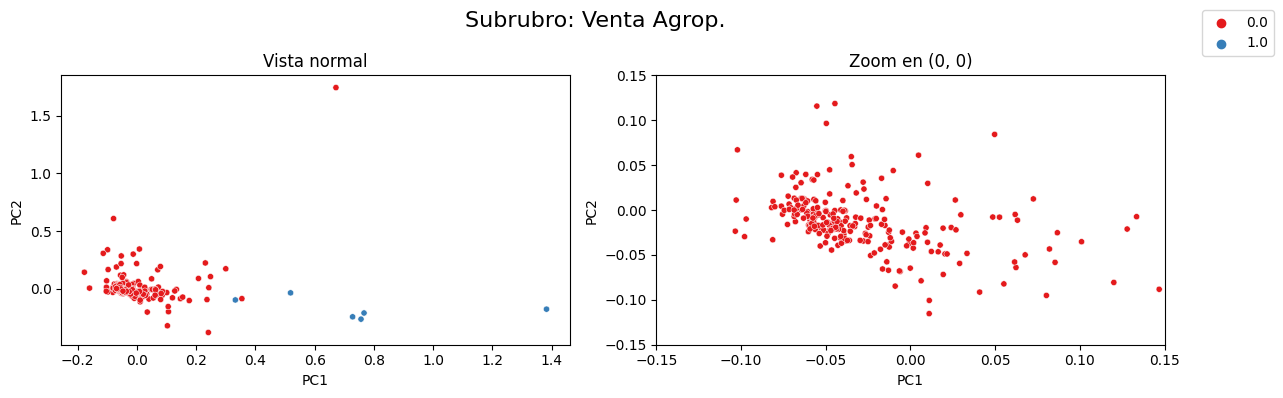

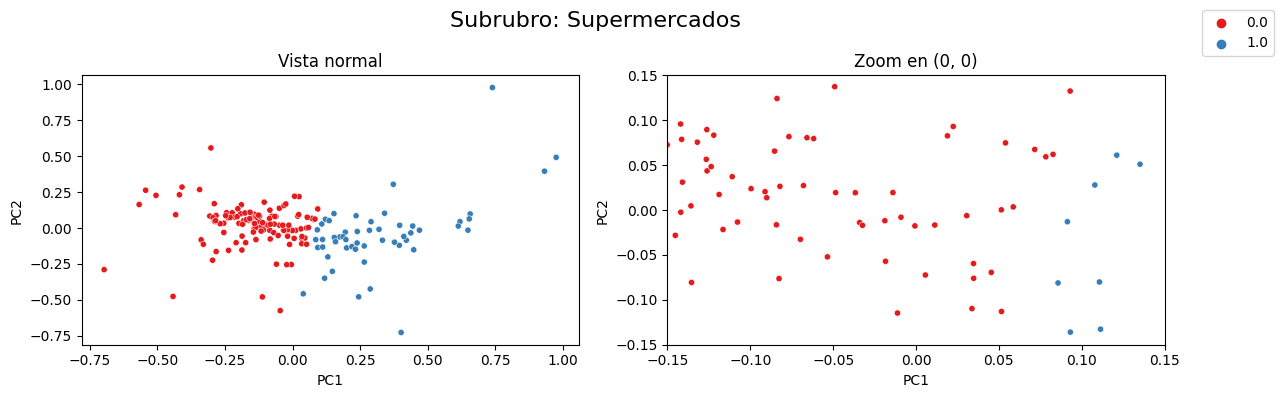

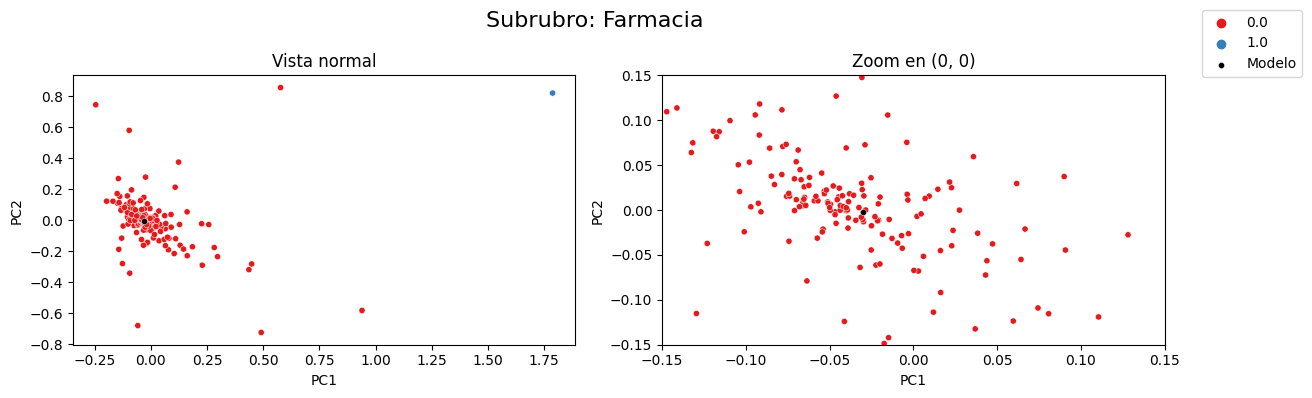

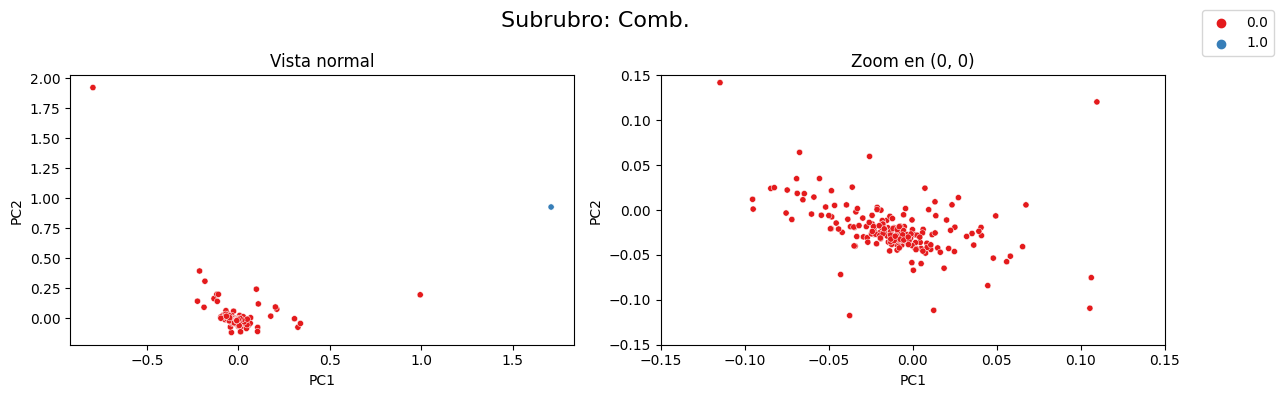

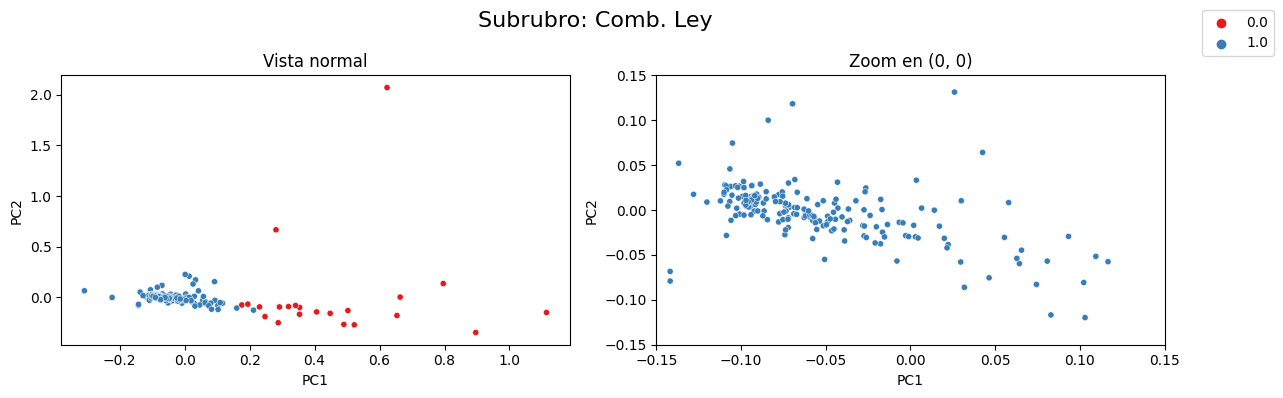

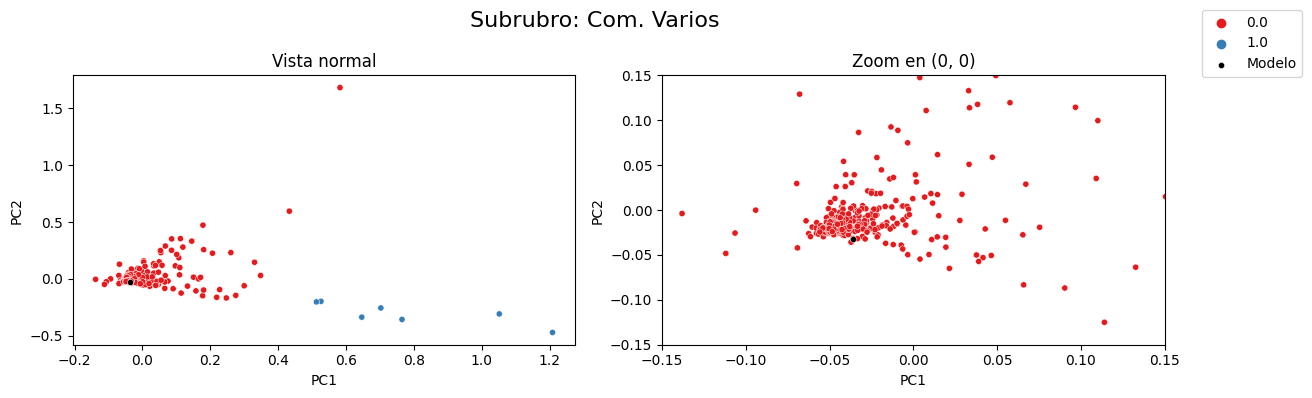

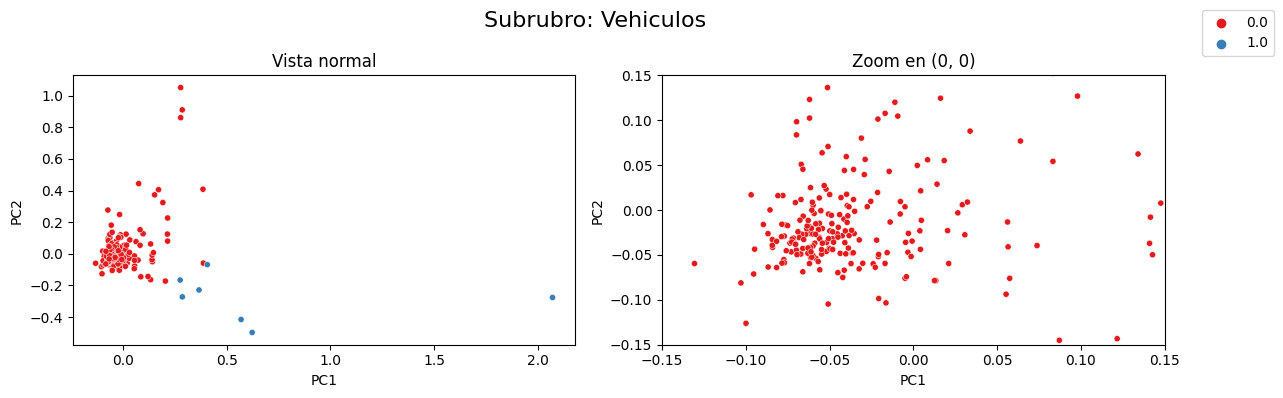

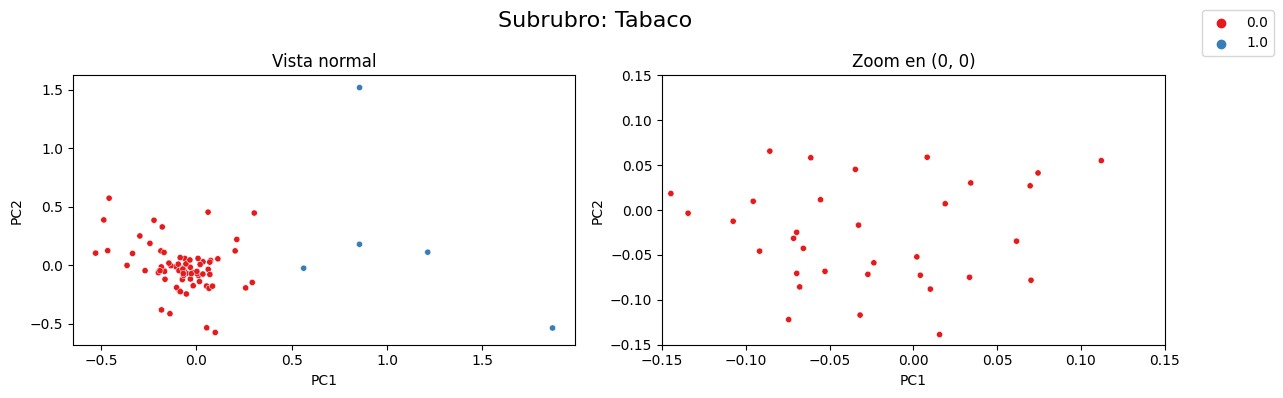

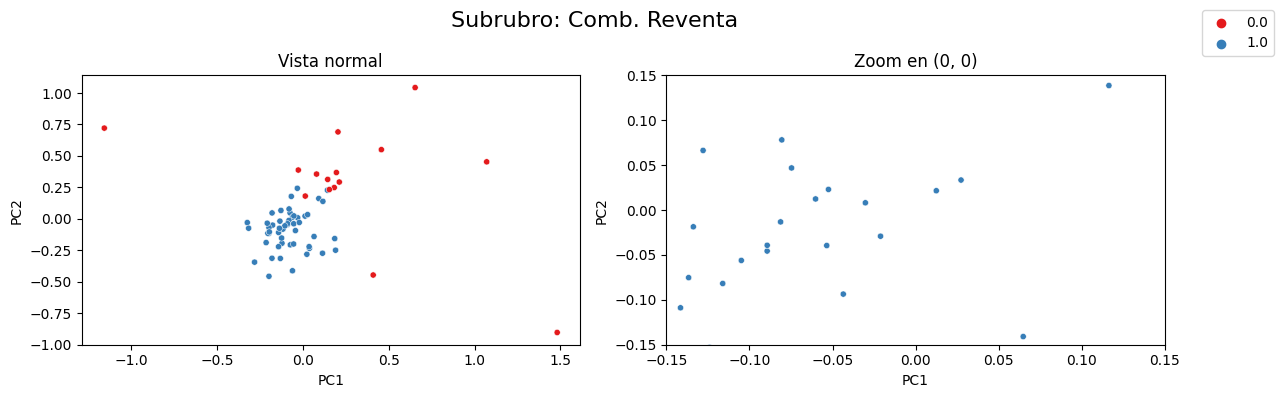

In [128]:
vectores = pd.read_csv('../data/interim/tp3_Fven_limpio_ceros.csv')

# Identificar subrubros
unique_subrubros = vectores['Subrubro'].unique()

# Itera sobre los subrubros únicos y crea gráficos para cada uno
for subrubro in unique_subrubros:
    subrubro_df = vectores[vectores['Subrubro'] == subrubro].copy()
    
    # Escala MinMax
    scaler = MinMaxScaler()
    subrubro_df[F_Ven] = scaler.fit_transform(subrubro_df[F_Ven])

    # PCA de 12 componentes
    pca = decomposition.PCA(n_components=12)
    pca.fit(subrubro_df[F_Ven])
    subrubro_df_pca = pca.transform(subrubro_df[F_Ven])
    subrubro_df_pca = pd.DataFrame(data=subrubro_df_pca, columns=[f'PC{i}' for i in range(1, 13)]).copy()

    # Nro de clusters elegido
    recommended_num_clusters = 2

    # KMeans
    km = KMeans(n_clusters=recommended_num_clusters, n_init=10)
    km.fit(subrubro_df_pca)
    clusters = km.labels_

    # PCA de 2 componentes para visualizar
    pca = decomposition.PCA(n_components=2)
    pca.fit(subrubro_df_pca)
    subrubro_df_pca_2 = pca.transform(subrubro_df_pca)  # numpy array
    subrubro_df_pca_2 = pd.DataFrame(data=subrubro_df_pca_2, columns=[f'PC{i}' for i in range(1, 3)]).copy()
    subrubro_df_clusters = subrubro_df_pca_2.copy()
    subrubro_df_clusters['kmeans_n'] = km.labels_
    subrubro_df_clusters = pd.concat([subrubro_df[basics], subrubro_df_clusters], axis=1)

    # Gráfico
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Subrubro: {subrubro}", fontsize=16)
    axs[0].set_title("Vista normal")
    axs[1].set_title("Zoom en (0, 0)")
    for ax in axs:
        sns.scatterplot(data=subrubro_df_clusters, x='PC1', y='PC2', hue='kmeans_n', palette='Set1', s=20, ax=ax)
    filt_modelo_1 = subrubro_df_clusters['Modelo'] == 1
    for ax in axs:
        sns.scatterplot(data=subrubro_df_clusters[filt_modelo_1], x='PC1', y='PC2', color='black', s=20, label='Modelo', ax=ax)
    axs[1].set_xlim(-0.15, 0.15)
    axs[1].set_ylim(-0.15, 0.15)
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [ ]:
#vectores_interes = vectores[basics + Y_Ven]
vectores_interes = vectores[Y_Ven]
vectores_interes.head()

In [ ]:
vectores_interes.info()

Hay problemas con los vacíos, para que me los tome el modelo:

In [ ]:
# Ventas anuales
vectores_interes = vectores[Y_Ven]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [ ]:
# Ventas anuales(zoom)
vectores_interes = vectores[Y_Ven]
msno.matrix(vectores_interes[185:190], fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [ ]:
vectores.iloc[186, :]

In [ ]:
vectores['Y_pct_Ven_2109'].max()

In [ ]:
vectores[vectores['Y_pct_Ven_2109'] == 203697461.3233292]

In [ ]:
ventas_fisc = pd.read_csv('../data/interim/tp2_ventas_fisc.csv')
ventas_fisc[(ventas_fisc['ID'] == 186) & (ventas_fisc['Subrubro'] == 'Com. Varios')]

In [ ]:
ventas_fisc[(ventas_fisc['ID'] == 186)]['Subrubro'].value_counts()

**HACER**
- Llevar a cero todo lo que está entre -1000 y +1000 (esto antes del tratamiento de inflación)

20/9 >> 2.287884e-02
21/9 >> 4.660361e+06
3017	1	Gondola de dónde viene para dar ese 10-2?



In [ ]:
ventas_fisc[ventas_fisc['ID'] == 3017]

In [ ]:
# Ventas cuatrimestrales
vectores_interes = vectores[F_Ven]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [ ]:
# Comisiones anuales
vectores_interes = vectores[Y_Com]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [ ]:
# Comisiones cuatrimestrales
vectores_interes = vectores[F_Com]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [ ]:
msno.bar(vectores_interes, fontsize=12, color="tab:blue", figsize=(10, 4))
plt.show()

In [ ]:
# Paso 1: Contar valores vacíos por fila
vacios_por_fila = vectores_interes.isnull().sum(axis=1)

# Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
resumen = vacios_por_fila.value_counts().reset_index()
resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
resumen.head()

# ** Chequear **  >> Esto borra teniendo en cuenta yearly

In [ ]:
plt.figure(figsize=(10, 4))  # Tamaño del gráfico
plt.bar(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], color='blue', alpha=0.7)
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor')
plt.xticks(resumen['Cantidad de Valores Vacíos'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Muestra el gráfico
plt.show()


También hay problema de outliers. Qué significa que una variación me dé -20.000%. Que tenía ej 1.000.000 y pasé a 0,05?. Algo hay que hacer

In [ ]:
vectores_interes.describe()

In [ ]:
# # Configuración del diseño del gráfico
# plt.figure(figsize=(16, 10))  # Tamaño del layout

# # Itera a través de cada columna y crea un KDE plot
# for column in vectores_interes.columns:
#     plt.subplot(5, 7, vectores_interes.columns.get_loc(column) + 1)  # 5 filas, 7 columnas
#     sns.kdeplot(vectores_interes[column], fill=True)
#     plt.title(column)

# # Ajusta la disposición y muestra el gráfico
# plt.tight_layout()
# plt.show()

In [ ]:
# Configuración del diseño del gráfico
plt.figure(figsize=(16, 10))  # Tamaño del layout

# Itera a través de cada columna y crea un boxplot
for i, column in enumerate(vectores_interes.columns):
    plt.subplot(5, 7, i + 1)  # 5 filas, 7 columnas
    sns.boxplot(x=vectores_interes[column])
    plt.title(column)

# Ajusta la disposición y muestra el gráfico
plt.tight_layout()
plt.show()

---
# Selección del Número de Clusters <span style="color:magenta">**(Paso 2)**</span>

### Elbow method

Para probar, le quito los vacíos.

In [ ]:
vectores_interes_sin_vacios.describe()

In [ ]:
gondola = vectores[vectores['Subrubro'] == 'Gondola']

#[basics + Y_Ven]
vectores_interes = gondola[Y_Ven]

In [ ]:
vectores_interes_sin_vacios = vectores_interes.dropna().copy()
print(vectores_interes_sin_vacios.shape)

# me quedo con el +-500% que se ve como un 5 acá OJO
vec_pm500 = vectores_interes_sin_vacios.where((vectores_interes_sin_vacios < 5) & (vectores_interes_sin_vacios > - 5))
vec_pm500 = vec_pm500.dropna()

vectores_interes_sin_vacios = vec_pm500

In [ ]:
vec_pm500.describe()

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_interes_sin_vacios).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

### Coeficiente Silhouette

---
## Aplicación de Modelos de Clustering <span style="color:magenta">**(Paso 3)**</span>

### K-means

In [ ]:
km = KMeans(n_clusters=3, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_interes_sin_vacios)
clusters = km.labels_

In [ ]:
vectores_clusters = vectores_interes_sin_vacios.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

In [ ]:
# Esto está hecho metiendo a todos los rubros en la misma bolsa
# Hacer por subrubro
vectores_clusters['kmeans_4'].value_counts()

In [ ]:
std_scale=preprocessing.StandardScaler().fit(vec_pm500)
X_scaled=std_scale.transform(vec_pm500) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más,

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


In [ ]:
X_tsne_kmeans_4 = pd.DataFrame(X_projected)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")#, alpha=0.25)

# sns.pairplot(X_projected)

In [ ]:
from sklearn import (manifold, preprocessing, decomposition)

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(vec_pm500)

In [ ]:
X_tsne_kmeans_4 = pd.DataFrame(X_tsne)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")

---


In [ ]:
gondola = vectores[vectores['Subrubro'] == 'Gondola']

#[basics + Y_Ven]
vectores_interes = gondola[F_Ven]

In [ ]:
vectores_interes_sin_vacios = vectores_interes.dropna().copy()
print(vectores_interes_sin_vacios.shape)

# me quedo con el +-500% que se ve como un 5 acá OJO
vec_pm500 = vectores_interes_sin_vacios.where((vectores_interes_sin_vacios < 5) & (vectores_interes_sin_vacios > - 5))
vec_pm500 = vec_pm500.dropna()

vectores_interes_sin_vacios = vec_pm500

In [ ]:
vec_pm500.describe()

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_interes_sin_vacios).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

### Coeficiente Silhouette

---
## Aplicación de Modelos de Clustering <span style="color:magenta">**(Paso 3)**</span>

### K-means

In [ ]:
km = KMeans(n_clusters=3, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_interes_sin_vacios)
clusters = km.labels_

In [ ]:
vectores_clusters = vectores_interes_sin_vacios.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

In [ ]:
# Esto está hecho metiendo a todos los rubros en la misma bolsa
# Hacer por subrubro
vectores_clusters['kmeans_4'].value_counts()

In [ ]:
pca=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más,

pca.fit(vec_pm500) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(vec_pm500) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


In [ ]:
X_tsne_kmeans_4 = pd.DataFrame(X_projected)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")#, alpha=0.25)

# sns.pairplot(X_projected)

In [ ]:
from sklearn import (manifold, preprocessing, decomposition)

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(vec_pm500)

In [ ]:
X_tsne_kmeans_4 = pd.DataFrame(X_tsne)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")

In [ ]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

Probando para un solo rubro..

In [ ]:
vectores_interes = vectores[basics + Y_Ven]
vectores_gondola = vectores_interes[vectores_interes['Subrubro'] == 'Gondola'].copy()
vectores_gondola = vectores_gondola.dropna().copy()
vectores_gondola

In [ ]:
vectores_gondola = vectores_gondola[Y_Ven].copy()

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_gondola).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [ ]:
km = KMeans(n_clusters=4, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_gondola)
clusters = km.labels_

In [ ]:
vectores_clusters = vectores_gondola.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

In [ ]:
vectores_clusters['kmeans_4'].value_counts()

In [ ]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

### Otros algoritmos de clustering

---
## Visualización de Resultados <span style="color:magenta">**(Paso 4)**</span>

---
## Interpretación y Evaluación <span style="color:magenta">**(Paso 5)**</span>

---
## Confianza en los Resultados <span style="color:magenta">**(Paso 6)**</span>

---
## Preguntas finales <span style="color:magenta">**(Paso 7)**</span>